# Exercise03 : Just Train in Your Working Machine

Fisrt, please train your script and model as usual.    
Here we don't use Azure Machine Learning services and just show our sample code using TensorFlow.

*back to [index](https://github.com/tsmatz/azure-ml-tensorflow-complete-sample/)*

Show top 3 images in test.tfrecords.

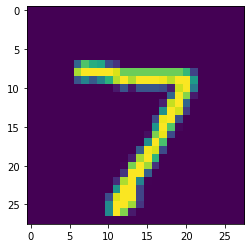

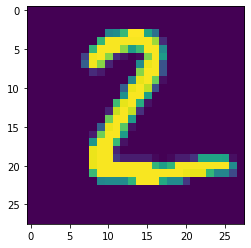

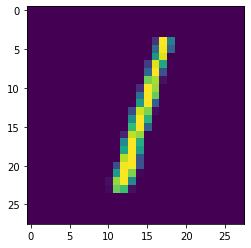

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

dataset = tf.data.TFRecordDataset('./data/test.tfrecords')
iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
data_org = iterator.get_next()
data_exam = tf.parse_single_example(
    data_org,
    features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
    })
data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
data_image = tf.reshape(data_image, [28, 28])

# Run tensor and get top 3 images
with tf.Session() as sess:
    for i in range(3):
        image = sess.run([data_image])
        plt.imshow(image[0])
        plt.show()

Train your model in local.

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import shutil
import argparse
import math

import tensorflow as tf

FLAGS = None
batch_size = 100

#
# define functions for Estimator
#

def _my_input_fn(filepath, num_epochs):
    # image - 784 (=28 x 28) elements of grey-scaled integer value [0, 1]
    # label - digit (0, 1, ..., 9)
    data_queue = tf.train.string_input_producer(
        [filepath],
        num_epochs = num_epochs) # data is repeated and it raises OutOfRange when data is over
    data_reader = tf.TFRecordReader()
    _, serialized_exam = data_reader.read(data_queue)
    data_exam = tf.parse_single_example(
        serialized_exam,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
    data_image.set_shape([784])
    data_image = tf.cast(data_image, tf.float32) * (1. / 255)
    data_label = tf.cast(data_exam['label'], tf.int32)
    data_batch_image, data_batch_label = tf.train.batch(
        [data_image, data_label],
        batch_size=batch_size)
    return {'inputs': data_batch_image}, data_batch_label

def _get_input_fn(filepath, num_epochs):
    return lambda: _my_input_fn(filepath, num_epochs)

def _my_model_fn(features, labels, mode):
    # with tf.device(...): # You can set device if using GPUs

    # define network and inference
    # (simple 2 fully connected hidden layer : 784->128->64->10)
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal(
                [784, FLAGS.first_layer],
                stddev=1.0 / math.sqrt(float(784))),
            name='weights')
        biases = tf.Variable(
            tf.zeros([FLAGS.first_layer]),
            name='biases')
        hidden1 = tf.nn.relu(tf.matmul(features['inputs'], weights) + biases)
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal(
                [FLAGS.first_layer, FLAGS.second_layer],
                stddev=1.0 / math.sqrt(float(FLAGS.first_layer))),
            name='weights')
        biases = tf.Variable(
            tf.zeros([FLAGS.second_layer]),
            name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal(
                [FLAGS.second_layer, 10],
                stddev=1.0 / math.sqrt(float(FLAGS.second_layer))),
        name='weights')
        biases = tf.Variable(
            tf.zeros([10]),
            name='biases')
        logits = tf.matmul(hidden2, weights) + biases
 
    # compute evaluation matrix
    predicted_indices = tf.argmax(input=logits, axis=1)
    if mode != tf.estimator.ModeKeys.PREDICT:
        label_indices = tf.cast(labels, tf.int32)
        accuracy = tf.metrics.accuracy(label_indices, predicted_indices)
        tf.summary.scalar('accuracy', accuracy[1]) # output to TensorBoard
 
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels=labels,
            logits=logits)
 
    # define operations
    if mode == tf.estimator.ModeKeys.TRAIN:
        #global_step = tf.train.create_global_step()
        #global_step = tf.contrib.framework.get_or_create_global_step()
        global_step = tf.train.get_or_create_global_step()        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=FLAGS.learning_rate)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=global_step)
        return tf.estimator.EstimatorSpec(
            mode,
            loss=loss,
            train_op=train_op)
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': accuracy
        }
        return tf.estimator.EstimatorSpec(
            mode,
            loss=loss,
            eval_metric_ops=eval_metric_ops)
    if mode == tf.estimator.ModeKeys.PREDICT:
        probabilities = tf.nn.softmax(logits, name='softmax_tensor')
        predictions = {
            'classes': predicted_indices,
            'probabilities': probabilities
        }
        export_outputs = {
            'prediction': tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,
            predictions=predictions,
            export_outputs=export_outputs)

def _my_serving_input_fn():
    inputs = {'inputs': tf.placeholder(tf.float32, [None, 784])}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

#
# Main
#

parser = argparse.ArgumentParser()
parser.add_argument(
    '--data_folder',
    type=str,
    default='./data',
    help='Folder path for input data')
parser.add_argument(
    '--chkpoint_folder',
    type=str,
    default='./logs',  # AML experiments logs folder
    help='Folder path for checkpoint files')
parser.add_argument(
    '--model_folder',
    type=str,
    default='./outputs',  # AML experiments outputs folder
    help='Folder path for model output')
parser.add_argument(
    '--learning_rate',
    type=float,
    default='0.07',
    help='Learning Rate')
parser.add_argument(
    '--first_layer',
    type=int,
    default='128',
    help='Neuron number for the first hidden layer')
parser.add_argument(
    '--second_layer',
    type=int,
    default='64',
    help='Neuron number for the second hidden layer')
FLAGS, unparsed = parser.parse_known_args()

# clean checkpoint and model folder if exists
if os.path.exists(FLAGS.chkpoint_folder) :
    for file_name in os.listdir(FLAGS.chkpoint_folder):
        file_path = os.path.join(FLAGS.chkpoint_folder, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
if os.path.exists(FLAGS.model_folder) :
    for file_name in os.listdir(FLAGS.model_folder):
        file_path = os.path.join(FLAGS.model_folder, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

# read TF_CONFIG
run_config = tf.estimator.RunConfig()

# create Estimator
mnist_fullyconnected_classifier = tf.estimator.Estimator(
    model_fn=_my_model_fn,
    model_dir=FLAGS.chkpoint_folder,
    config=run_config)
train_spec = tf.estimator.TrainSpec(
    input_fn=_get_input_fn(os.path.join(FLAGS.data_folder, 'train.tfrecords'), 2),
    max_steps=60000 * 2 / batch_size)
eval_spec = tf.estimator.EvalSpec(
    input_fn=_get_input_fn(os.path.join(FLAGS.data_folder, 'test.tfrecords'), 1),
    steps=10000 * 1 / batch_size,
    start_delay_secs=0)

# run !
tf.estimator.train_and_evaluate(
    mnist_fullyconnected_classifier,
    train_spec,
    eval_spec
)

# save model and variables
model_dir = mnist_fullyconnected_classifier.export_savedmodel(
    export_dir_base = FLAGS.model_folder,
    serving_input_receiver_fn = _my_serving_input_fn)
print('current working directory is ', os.getcwd())
print('model is saved ', model_dir)

INFO:tensorflow:Using config: {'_model_dir': './logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7d4c603cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locall

Predict using generated model. This code will be used in "[Exercise08 : Publish as a Web Service](https://github.com/tsmatz/azure-ml-tensorflow-complete-sample/blob/master/notebooks/exercise08_publish_model.ipynb)".

In [8]:
import tensorflow as tf

# Read data by tensor
dataset = tf.data.TFRecordDataset('./data/test.tfrecords')
iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
data_org = iterator.get_next()
data_exam = tf.parse_single_example(
    data_org,
    features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
    })
data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
data_image.set_shape([784])
data_image = tf.cast(data_image, tf.float32) * (1. / 255)
data_label = tf.cast(data_exam['label'], tf.int32)

# Run tensor and get top 3 data
with tf.Session() as sess:
    image_arr = []
    label_arr = []
    for i in range(3):
        image, label = sess.run([data_image, data_label])
        image_arr.append(image)
        label_arr.append(label)

# Predict
pred_fn = tf.contrib.predictor.from_saved_model(model_dir)
pred = pred_fn({'inputs': image_arr})

print('Predicted: ', pred['classes'].tolist())
print('Actual   : ', label_arr)

INFO:tensorflow:Restoring parameters from ./outputs/1587694297/variables/variables
Predicted:  [7, 2, 1]
Actual   :  [7, 2, 1]
